In [42]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [5]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS = 3

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2153 files belonging to 3 classes.


In [7]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 1 2 0 0 0 1 0 0 0 1 0 0 0 0 2 2 1 1 1 0 1 1 0 2 0 1 0 1 0 1]


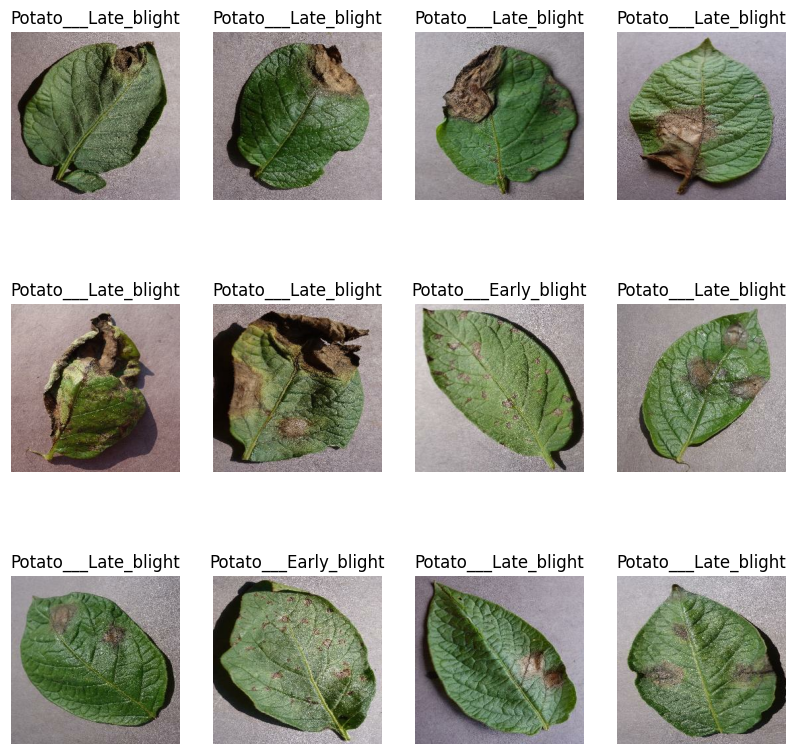

In [10]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

68

In [11]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds=dataset.take(54)
len(train_ds)

54

In [13]:
dataset.skip(54)

<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds


In [19]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
#Model Implementation

In [23]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [28]:
history=model.fit(train_ds,epochs=50,
                  batch_size=BATCH_SIZE,
                  verbose=1,
                  validation_data=val_ds)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)


Epoch 1/50


54/54 [==============================] - 32s 511ms/step - loss: 0.9030 - accuracy: 0.4809 - val_loss: 0.8207 - val_accuracy: 0.7396
Epoch 2/50
54/54 [==============================] - 27s 506ms/step - loss: 0.5529 - accuracy: 0.7841 - val_loss: 0.4579 - val_accuracy: 0.8490
Epoch 3/50
54/54 [==============================] - 28s 517ms/step - loss: 0.3904 - accuracy: 0.8316 - val_loss: 0.2665 - val_accuracy: 0.8876
Epoch 4/50
54/54 [==============================] - 28s 511ms/step - loss: 0.2549 - accuracy: 0.8947 - val_loss: 0.2134 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 28s 526ms/step - loss: 0.2088 - accuracy: 0.9253 - val_loss: 0.2863 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 29s 529ms/step - loss: 0.1505 - accuracy: 0.9416 - val_loss: 0.2630 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 29s 535ms/step - loss: 0.1448 - accuracy: 0.9433 - val_loss: 0.0870 - val_accuracy: 0.96

NameError: name 'EarlyStopping' is not defined

In [31]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 1s 104ms/step - loss: 0.0169 - accuracy: 0.9961


In [32]:
scores

[0.016871917992830276, 0.99609375]

In [33]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

In [46]:
loss=history.history['loss']
val_loss=history.history['val_loss']

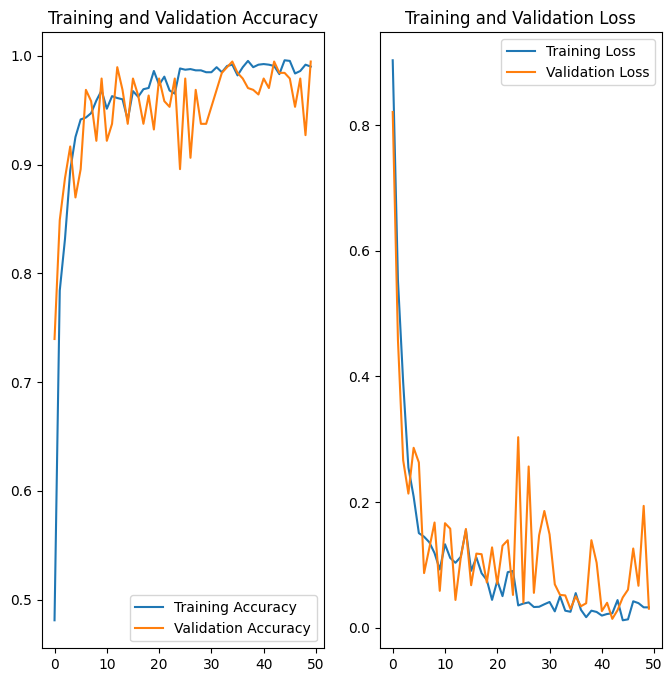

In [47]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label="Training Accuracy")
plt.plot(range(50), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label="Training Loss")
plt.plot(range(50), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()


First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 0s 218ms/step
[5.505149e-06 9.999945e-01 4.085474e-09]


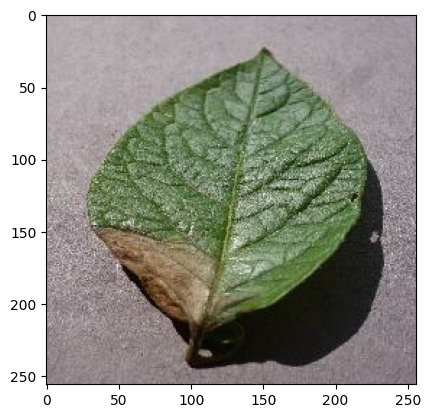

In [78]:
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print(batch_prediction[0])

In [64]:
np.argmax([5.505149e-06,9.999945e-01,4.085474e-09])

1

In [61]:
print("predicted label:",class_names[np.argmax(batch_prediction[0])])

predicted label: Potato___Late_blight


In [90]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 32ms/step


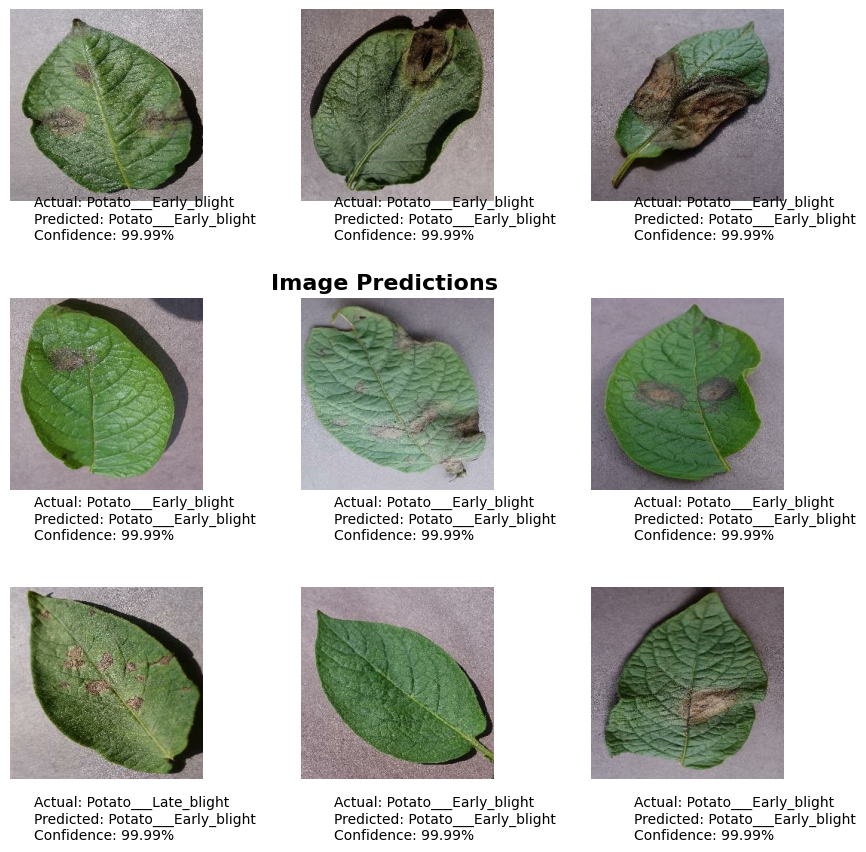

In [97]:
# Create a figure and adjust its size
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing between subplots
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.axis("off")

# Add text annotations to the entire figure
plt.figtext(0.5, 0.6, "Image Predictions", horizontalalignment='center', fontsize=16, fontweight='bold')

for i, (images, labels) in enumerate(test_ds.take(1)):
    for j in range(9):
        predicted_class, confidence = predict(model, images[j].numpy())
        actual_class = class_names[labels[j]]
        plt.figtext(0.3 * (j % 3) + 0.15, 0.65 - 0.3 * (j // 3), f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=10, ha='left')

plt.show()


In [99]:
import os

model_version = 1
model_save_dir = f"../models/{model_version}"
os.makedirs(model_save_dir, exist_ok=True)
model.save(model_save_dir)

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
